# GAN (Generative Adverserial Network)

In this project, we develop and compare deep learning models for image reconstruction and synthetic image generation using the Kirmizi dataset, where all input images are resized to 100×100 pixels to match the model input requirements.

Two autoencoder models are would be compared:
1. The baseline autoencoder is a symmetric convolutional architecture designed to reconstruct input images by compressing and then reconstructing features using pooling and upsampling operations. The architecture is as follows:
- Generator

| Layer     | Type   | Out Channels | Kernel | Stride | Padding | Activation | Output Shape |
| --------- | ------ | ------------ | ------ | ------ | ------- | ---------- | ------------ |
| Conv2D_1  | Conv2D | 16           | 3×3    | 1      | same    | ReLU       | (100, 100, 16) |
| Conv2D_2  | Conv2D | 32           | 3×3    | 1      | same    | ReLU       | (100, 100, 32) |
| Conv2D_3  | Conv2D | 64           | 3×3    | 1      | same    | ReLU       | (100, 100, 64) |
| Conv2D_4  | Conv2D | 3            | 3×3    | 1      | same    |   Tanh     | (100, 100, 3)  |


- Discriminator

| Layer     | Type   | Out Channels | Kernel | Stride | Padding | Activation | Output Shape |
| --------- | ------ | ------------ | ------ | ------ | ------- | ---------- | ------------ |
| Conv2D_1  | Conv2D | 16           | 3×3    | 1      | same    | ReLU       | (100, 100, 16) |
| Conv2D_2  | Conv2D | 32           | 3×3    | 1      | same    | ReLU       | (100, 100, 32) |
| Conv2D_3  | Conv2D | 64           | 3×3    | 1      | same    | ReLU       | (100, 100, 64) |
| Flatten   | -      | -            | -      | -      | -       | -          | (640000)    |
| Linear    | Dense  | 1            | -      | -      | -       | Sigmoid    | (1)          |

- Loss: Binary Cross-Entropy
- Optimizer: Adam for both Generator & Discriminator

2. A GAN model based on wgan made by <a href="https://github.com/eriklindernoren/PyTorch-GAN.git">(eriklindernoren, 2019)</a>.
- Generator

| Layer        | Type                         | Output Size             | Activation      |
| ------------ | ---------------------------- | ----------------------- | --------------- |
| Linear_0    | Fully Connected (100 → 128)  | 128                     | LeakyReLU |
| BatchNorm_0 | BatchNorm1d                  | 128                     | -               |
| Linear_1    | Fully Connected (128 → 256)  | 256                     | LeakyReLU |
| BatchNorm_1 | BatchNorm1d                  | 256                     | -               |
| Linear_2    | Fully Connected (256 → 512)  | 512                     | LeakyReLU |
| BatchNorm_2 | BatchNorm1d                  | 512                     | -               |
| Linear_3    | Fully Connected (512 → 1024) | 1024                    | LeakyReLU |
| BatchNorm_3 | BatchNorm1d                  | 1024                    | -               |
| Linear_4    | Fully Connected (1024 → 10000) | 10000 (flattened)       | Tanh            |
| Reshape     | -                            | (1, 100, 100)           | -               |

- Discriminator

| Layer     | Type                        | Output Size | Activation      |
| --------- | --------------------------- | ----------- | --------------- |
| Linear_0 | Fully Connected (10000 → 512) | 512         | LeakyReLU |
| Linear_1 | Fully Connected (512 → 256) | 256         | LeakyReLU |
| Linear_2 | Fully Connected (256 → 1)   | 1           | - (Raw Score)   |

- Loss Function: Wasserstein loss (critic output mean-based)
- Optimizer: RMSProp for both Generator and Discriminator
- Gradient Clipping: Discriminator weights clipped to ±0.01 (WGAN requirement)
- Training Strategy: Discriminator trained 5× per Generator update

All images were resized to 100x100 to match model input requirements.

## Import Libraries

In [ ]:
# Common Python Libraries
import numpy as np
import pandas as pd
import os
import glob
from tqdm import tqdm
import time
from IPython.display import clear_output
import joblib
import random
import cv2
from PIL import Image
import pynvml

# plotting libraries
import matplotlib.pyplot as plt

# Deep Learning Libraries
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import torch
import torch.nn as nn
import torch.nn.functional as F

## GPU Check

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if torch.cuda.is_available():
    print("Pytorch is using the GPU")

    pynvml.nvmlInit()

    num_gpus = pynvml.nvmlDeviceGetCount()

    for i in range(num_gpus):
        handle = pynvml.nvmlDeviceGetHandleByIndex(i)
        gpu_name = pynvml.nvmlDeviceGetName(handle)
        print("GPU Name:", gpu_name)

    pynvml.nvmlShutdown()
else:
    print("Pytorch is not using the GPU")

Pytorch is not using the GPU


In [3]:
print("Num GPUs Available: ", torch.cuda.device_count())

Num GPUs Available:  0


In [4]:
project_path = "./"

## Import Data

In [5]:
def img_to_df(img_path: str):
    """
    Convert image paths to DataFrame. for easier data preprocessing.
    
    Args:
        img_path (str): Path to the folder containing the image.
    
    Returns:
        pd.DataFrame: DataFrame containing image path, label, width, height, and channel_info.
    """
    #checks
    if not isinstance(img_path, str):
        raise TypeError("img_path must be a string.")
    if not os.path.exists(img_path):
        raise FileNotFoundError(f"The path {img_path} does not exist.")
    if not os.path.isdir(img_path):
        raise NotADirectoryError(f"The path {img_path} is not a directory.")
    
    # Get the list of all image files in the directory
    glob_path = os.path.join(img_path, "**", "*.jpg")
    print(f"glob_path: {glob_path}")
    
    image_path = glob.glob(glob_path, recursive=True) #recursive=True is to allow for subdirectories to be searched
    print(f"image_path: {image_path}")
    
    # Get the width, height, and channel information of the images
    width = []
    height = []
    channel_info = []
    avg_red = []
    avg_green = []
    avg_blue = []
    
    for path in tqdm(image_path, desc="Processing images", unit="image"):
        img = cv2.imread(path)
        if img is None:
            print(f"Skipping corrupted image: {path}")
            continue

        h, w, c = img.shape
        average = img.mean(axis=0).mean(axis=0)
        
        # Append to the list
        height.append(h)
        width.append(w)
        channel_info.append(c)
        avg_blue.append(average[0])
        avg_green.append(average[1])
        avg_red.append(average[2])
        
        
    #combine into one dataframe
    df = pd.DataFrame({
        "image_path": image_path,
        "width": width,
        "height": height,
        "channel_info": channel_info,
        "img_avg_red": avg_red,
        "img_avg_green": avg_green,
        "img_avg_blue": avg_blue
    })
    
    return df

### Caching function

In [6]:
def save_cache(data, filename):
    """This is a function to save the data to a file using joblib

    Args:
        data (_type_): data to be saved
        filename (_type_): the name of the file to save the data to
    """
    with open(filename, 'wb') as f:
        joblib.dump(data, f)
    print(f"Data saved to {filename}")

def load_cache(filename):
    """This is a function to load the data to a file using joblib

    Args:
        data (_type_): data to be saved
        filename (_type_): the name of the file to load the data to
    """
    with open(filename, 'rb') as f:
        return joblib.load(f)
    print(f"Data loaded from {filename}")

In [7]:
data_path = os.path.join(project_path, "dataset/")
write_path = "./Cache/"

if not os.path.exists(write_path):
            os.makedirs(write_path)

csv_path = os.path.join(write_path, "path_dataset.csv")

# We will cache the data so that it will load faster
if os.path.exists(csv_path):
    print("Loading cached dataset...")
    img_df = pd.read_csv(csv_path)
    print("Cached dataset loaded")
else:
    print("Creating and caching dataset...")
    img_df = img_to_df(data_path)
    img_df.to_csv(csv_path, index=False)

Loading cached dataset...
Cached dataset loaded


In [8]:
img_df.head()

,image_path,width,height,channel_info,img_avg_red,img_avg_green,img_avg_blue
0,./dataset/kirmizi 680.jpg,600,600,3,26.872642,25.172472,24.834806
1,./dataset/kirmizi 986.jpg,600,600,3,55.434728,53.172314,50.263817
2,./dataset/kirmizi 1000.jpg,600,600,3,47.494778,45.017839,39.948303
3,./dataset/kirmizi 1001.jpg,600,600,3,51.244636,49.768544,47.024422
4,./dataset/kirmizi 1002.jpg,600,600,3,35.940481,33.959889,30.202314


## EDA

In [9]:
#setting the colors generator
def fill_color_generator():
    """This generates a color

    Returns:
        color: An R,G,B value with a range of 0 to 1
    """
    r = random.randint(0, 255)
    g = random.randint(0, 255)
    b = random.randint(0, 255)
    return (r/255, g/255, b/255)

In [10]:
#function for plotting numerical data distribution
def numeric_dist_plot(data: pd.DataFrame):
    """This function creates a plot of the distribution of the numerical data.

    Args:
        data (pd.DataFrame): Numeric pandas dataframe

    Raises:
        TypeError: The following columns are not numeric: {non_numeric_cols}
        This is due to some of the columns are not numeric.

    Returns:
        Displays a plot of
    """
    # Checks
    ## Check if all columns are numeric
    non_numeric_cols = [col for col in data.columns if not pd.api.types.is_numeric_dtype(data[col])]
    if non_numeric_cols:
        raise TypeError(f"The following columns are not numeric: {non_numeric_cols}")

    # Plotting the numerical data
    #titles for plots/figures
    fig_titles = []

    for colName in data.columns:
        fig_titles.append(f"Boxplot Of {colName}")
        fig_titles.append(f"Histogram Of {colName}")

    fill_color_dict = {}
    for colName in data.columns:
        fill_color_dict[colName] = fill_color_generator()

    # make subplot for each column name
    num_rows = len(data.columns)
    fig, axes = plt.subplots(nrows=num_rows, ncols=2, figsize=(12, num_rows * 3))

    # Flatten axes for easier indexing when there's more than 1 row
    axes = axes if num_rows > 1 else [axes]

    for i, column in enumerate(data.columns):
        color = fill_color_dict[column]

        # Boxplot
        axes[i][0].boxplot(data[column].dropna(), vert=False, patch_artist=True,
                        boxprops=dict(facecolor=color, color=color),
                        medianprops=dict(color="black"))
        axes[i][0].set_title(f"Boxplot of {column}")
        axes[i][0].set_xlabel(column)

        # Histogram
        axes[i][1].hist(data[column].dropna(), bins=20, color=color, alpha=0.7, edgecolor='black')
        axes[i][1].set_title(f"Histogram of {column}")
        axes[i][1].set_xlabel(column)

    # Overall layout
    fig.suptitle("Boxplot and Distribution Visualization for Each Numeric Column", fontsize=16)
    fig.tight_layout(rect=[0, 0, 1, 0.97])  # Adjust layout to fit title
    return plt

In [11]:
numeric_data = img_df.select_dtypes(include=[np.number])
numeric_data.columns

Index(['width', 'height', 'channel_info', 'img_avg_red', 'img_avg_green',
       'img_avg_blue'],
      dtype='object')

<module 'matplotlib.pyplot' from '/home/andrew/miniconda3/envs/torch-env/lib/python3.11/site-packages/matplotlib/pyplot.py'>

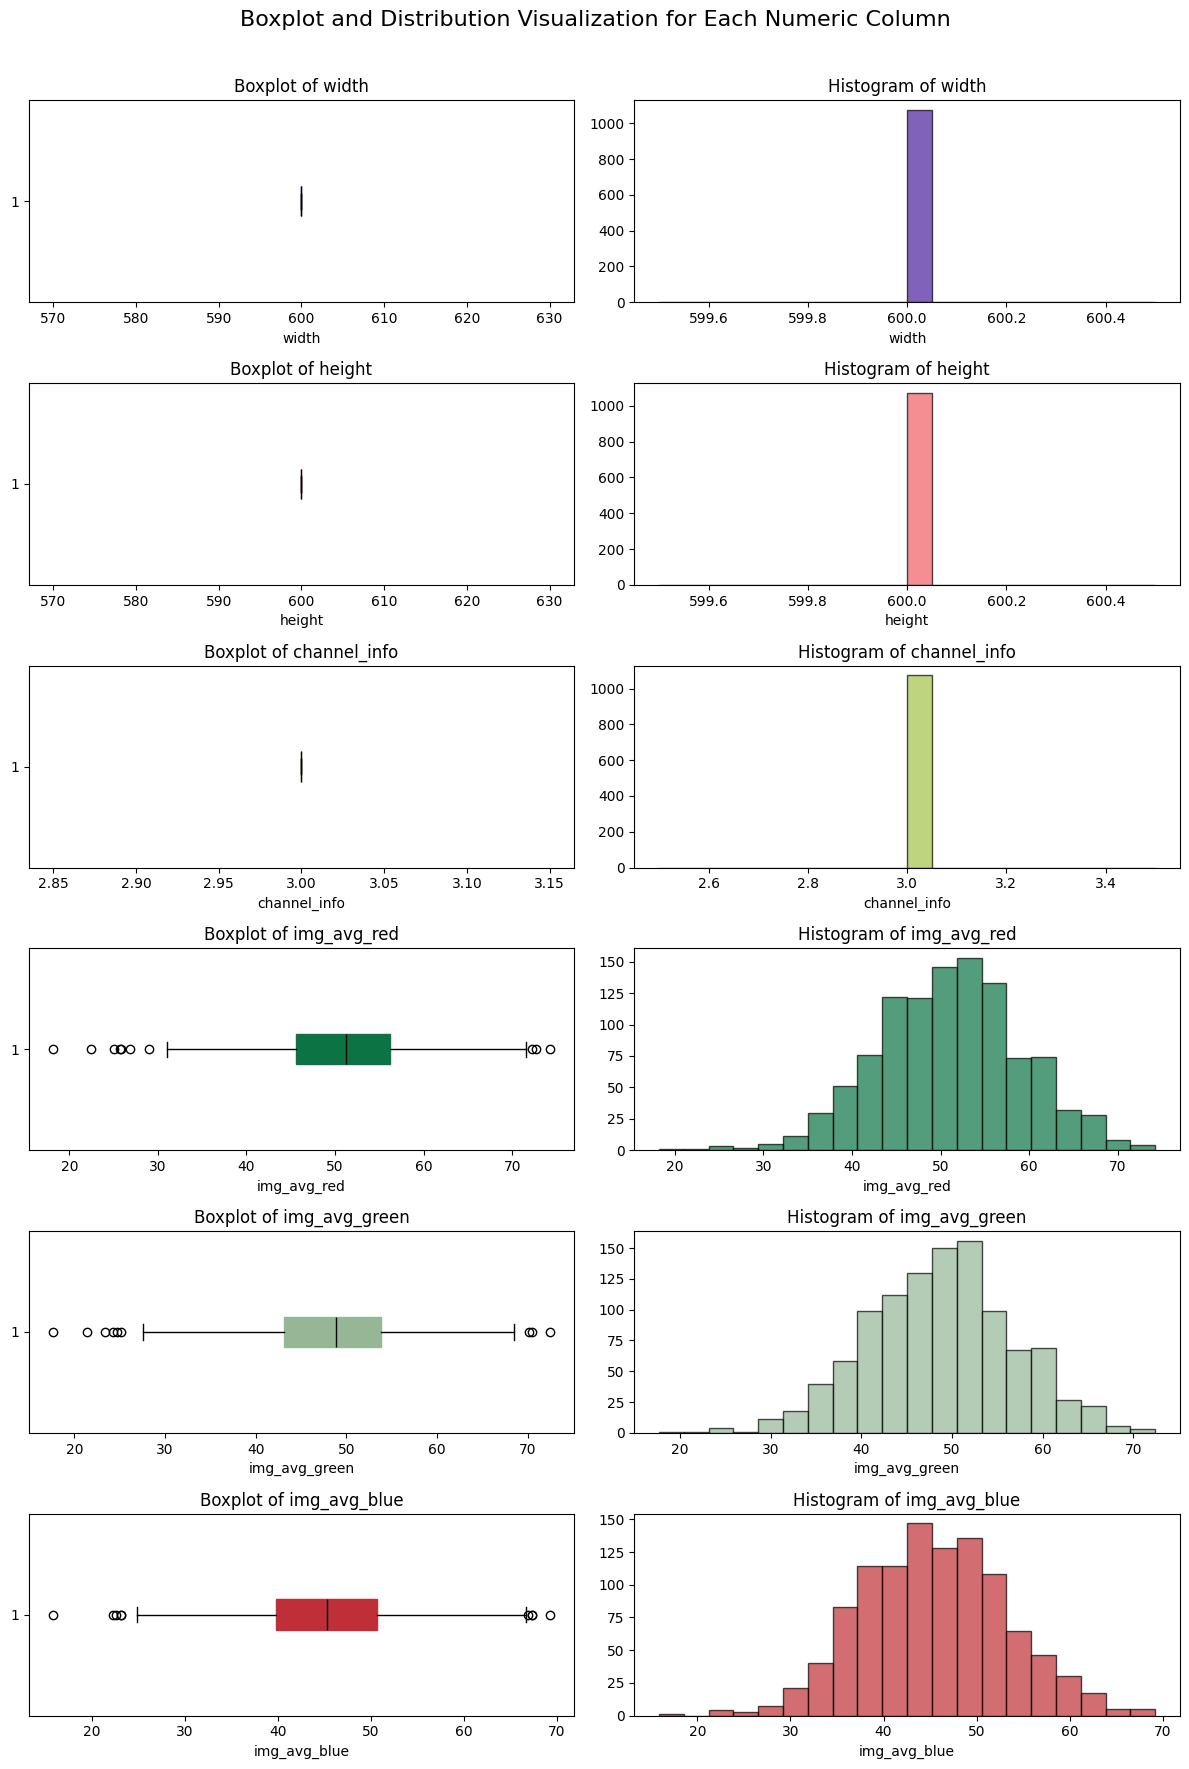

In [12]:
numeric_dist_plot(numeric_data)

## Model Making (continue in colab)

### Data Loader

In [13]:
class ImgDataset(Dataset):
    def __init__(self, img_paths, transform=None):
        self.img_paths = img_paths
        self.transform = transform or transforms.Compose([
            transforms.Resize((100, 100)),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # convert from [0,1] values from ToTensor to [-1, 1] for tanh. And 3 channels (R, G, B)
        ])
        
    def __len__(self):
        return len(self.img_paths)
    
    def __getitem__(self, idx):
        img = Image.open(self.img_paths[idx]).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img

In [14]:
img_dataset = ImgDataset(img_df['image_path'].values, transform=None)

img_loader = DataLoader(img_dataset, batch_size=32, shuffle=True)

### Baseline Model

In [15]:
class BaselineGAN(nn.Module):
    def __init__(self):
        super(BaselineGAN, self).__init__()

        # Generator
        self.generator = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),  # → (98, 98)
            nn.ReLU(),

            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),  # → (96, 96)
            nn.ReLU(),

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),  # → (94, 94)
            nn.ReLU(),

            nn.Conv2d(64, 3, kernel_size=3, stride=1, padding=1),   # → (92, 92)
            nn.Tanh()
        )

        # Discriminator
        self.discriminator = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),  # → (98, 98)
            nn.ReLU(),

            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),  # → (96, 96)
            nn.ReLU(),

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),  # → (94, 94)
            nn.ReLU(),

            nn.Flatten(),
            nn.Linear(100 * 100 * 64, 1),
            nn.Sigmoid()
        )

    def generate(self, img):
        return self.generator(img)

    def discriminate(self, img):
        return self.discriminator(img)


#### Training loop

In [16]:
# Loss function
adversarial_loss = nn.BCELoss()

# Move model to device
baseline_model = BaselineGAN().to(device)

# Optimizers
optimizer_G = torch.optim.Adam(baseline_model.generator.parameters(), lr=0.0002)
optimizer_D = torch.optim.Adam(baseline_model.discriminator.parameters(), lr=0.0002)

# Training loop
epochs = 20

for epoch in range(epochs):
    for i, real_imgs in enumerate(img_loader):
        real_imgs = real_imgs.to(device)

        # Real and fake labels
        valid = torch.ones(real_imgs.size(0), 1, device=device)
        fake = torch.zeros(real_imgs.size(0), 1, device=device)

        ## Train Generator
        optimizer_G.zero_grad()

        # Generate fake image from real image
        gen_imgs = baseline_model.generate(real_imgs)

        # Generator loss: try to fool the discriminator
        g_loss = adversarial_loss(baseline_model.discriminate(gen_imgs), valid)

        g_loss.backward()
        optimizer_G.step()
        
        ## Train Discriminator
        optimizer_D.zero_grad()

        # Discriminator loss on real and generated images
        real_loss = adversarial_loss(baseline_model.discriminate(real_imgs), valid)
        fake_loss = adversarial_loss(baseline_model.discriminate(gen_imgs.detach()), fake)

        d_loss = (real_loss + fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()

        # Print progress every 5 iterations
        if i % 5 == 0:
            print(f"[Epoch {epoch}/{epochs}] [Batch {i}/{len(img_loader)}] "
                  f"[Discriminator loss: {d_loss.item():.4f}] [Generator loss: {g_loss.item():.4f}]")


[Epoch 0/20] [Batch 0/34] [Discriminator loss: 0.6945] [Generator loss: 0.6890]
[Epoch 0/20] [Batch 5/34] [Discriminator loss: 0.0090] [Generator loss: 5.2084]
[Epoch 0/20] [Batch 10/34] [Discriminator loss: 0.0008] [Generator loss: 6.4624]
[Epoch 0/20] [Batch 15/34] [Discriminator loss: 0.0049] [Generator loss: 4.6783]


KeyboardInterrupt: 

In [ ]:
# Save Baseline Model
baseline_model = BaselineGAN().to(device)
baseline_model_path = os.path.join(project_path, "models/baselineGAN_model.pt")
os.makedirs(os.path.dirname(baseline_model_path), exist_ok=True)
torch.save(baseline_model.state_dict(), baseline_model_path)
print("📦 Baseline Model saved successfully!")

### Proposed Model

In [19]:
class ProposedGAN(nn.Module):
    def __init__(self):
        super(ProposedGAN, self).__init__()

        # Generator
        self.generator = nn.Sequential(
            nn.Linear(100, 128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.BatchNorm1d(128), # Normalize output of linear layer to 1D feature maps (to prevent vanising or exploding gradient)
            nn.Linear(128, 256),
            nn.LeakyReLU(0.2, inplace=True),

            nn.BatchNorm1d(256),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2, inplace=True),

            nn.BatchNorm1d(512),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2, inplace=True),

            nn.BatchNorm1d(1024),
            nn.Linear(1024, 3 * 100 * 100),  # 100x100 image 3 channels, flattened
            nn.Tanh()  # Output in range [-1, 1]
        )

        # Discriminator
        self.discriminator = nn.Sequential(
            nn.Linear(3 * 100 * 100, 512),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Linear(256, 1)  # No sigmoid if using WGAN
        )

    def generate(self, img):
        return self.generator(img)

    def discriminate(self, img):
        return self.discriminator(img)


In [21]:
# Move model to device
proposed_model = ProposedGAN().to(device)

# Optimizers
optimizer_G = torch.optim.RMSprop(proposed_model.generator.parameters(), lr=0.00005)
optimizer_D = torch.optim.RMSprop(proposed_model.discriminator.parameters(), lr=0.00005)

epochs = 20
n_critic = 2  # WGAN: train discriminator more often
clip_value = 0.01  # WGAN: clip discriminator weights

for epoch in range(epochs):
    for i, real_imgs in enumerate(img_loader):
        real_imgs = real_imgs.to(device)
        real_imgs = real_imgs.view(real_imgs.size(0), -1)  # flatten to [B, 10000]

        #  Train Discriminator
        optimizer_D.zero_grad()

        # Generate fake images
        z = torch.randn(real_imgs.size(0), 100).to(device)
        fake_imgs = proposed_model.generate(z).detach()

        # Wasserstein loss
        d_loss = torch.mean(proposed_model.discriminate(fake_imgs)) - torch.mean(proposed_model.discriminate(real_imgs))

        d_loss.backward()
        optimizer_D.step()

        # Clip weights of discriminator
        for p in proposed_model.discriminator.parameters():
            p.data.clamp_(-clip_value, clip_value)

        # Only update generator every n_critic steps
        if i % n_critic == 0:
            #  Train Generator
            optimizer_G.zero_grad()

            # Generate fake images again
            z = torch.randn(real_imgs.size(0), 100).to(device)
            gen_imgs = proposed_model.generate(z)

            # Generator wants discriminator to output high scores (real-like)
            g_loss = -torch.mean(proposed_model.discriminate(gen_imgs))

            g_loss.backward()
            optimizer_G.step()

    print(f"[Epoch {epoch}/{epochs}]"
            f"[D loss: {d_loss.item():.4f}] [G loss: {g_loss.item():.4f}]")

[Epoch 0/20][D loss: -225.1844] [G loss: -40.5831]
[Epoch 1/20][D loss: -485.4951] [G loss: -88.9364]


KeyboardInterrupt: 

In [ ]:
# Save Proposed Model
proposed_model = ProposedGAN().to(device)
proposed_model_path = os.path.join(project_path, "models/ProposedGAN_model.pt")
os.makedirs(os.path.dirname(proposed_model_path), exist_ok=True)
torch.save(proposed_model.state_dict(), proposed_model_path)
print("📦 Proposed Model saved successfully!")


In [ ]:
# Load Baseline Model
baseline_model_path = os.path.join(project_path, "models/baselineGAN_model.pt")
loaded_baseline_model = BaselineGAN().to(device)
loaded_baseline_model.load_state_dict(torch.load(baseline_model_path))
loaded_baseline_model.eval()
print("✅ Baseline Model loaded and ready to use!")

# Load Proposed Model
proposed_model_path = os.path.join(project_path, "models/ProposedGAN_model.pt")
loaded_proposed_model = ProposedGAN().to(device)
loaded_proposed_model.load_state_dict(torch.load(proposed_model_path))
loaded_proposed_model.eval()
print("✅ Proposed Model loaded and ready to use!")


## Conclusion
After Running both models with 100 epochs we recieve the following:
1. Baseline Model

| **Epoch** | **Discriminator Loss** | **Generator Loss** | **Notes**                                                             |
| --------- | ---------------------- | ------------------ | --------------------------------------------------------------------- |
| 0         | 0.0003                 | 7.7801             | Discriminator very confident; generator just starting out             |
| 20        | 0.5899                 | 1.2628             | Generator improving; discriminator less sure                          |
| 40        | 5.8211                 | 0.0030             | generator overpowering the discriminator |
| 60        | 1.4991                 | 1.4447             | More balanced; decent tension between G and D                         |
| 80        | 0.2813                 | 1.4493             | Discriminator regaining strength; generator still trying              |

2. Proposed model WGAN

| **Epoch** | **Discriminator Loss (WGAN)** | **Generator Loss (WGAN)** | **Notes**                                                                    |
| --------- | ----------------------------- | ------------------------- | ---------------------------------------------------------------------------- |
| 0         | -252.5182                     | -47.0802                  | Typical early WGAN losses; G starting weak                                   |
| 20        | -492.4785                     | -546.8459                 | G and D both producing large negative scores              |
| 40        | -369.3113                     | -802.0580                 | Generator might be producing very confident fakes, but could be unstable     |
| 60        | -439.9628                     | -712.8312                 | Still heavily negative; may suggest mode collapse or very confident outputs  |
| 80        | -182.8279                     | -768.9496                 | Discriminator weakening; generator output very confident (possibly too much) |
